In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio # for loading MATLAB files
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter, filtfilt, iirnotch, sosfiltfilt, welch

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import os

## Ninapro dataset

In [2]:
data_DB3_s1_E1 = loadmat("data/DB3/DB3_s1/S1_E1_A1.mat")
print(f"What kind of data structure are we working with? {type(data_DB3_s1_E1)}")
print(f"What are the keys of the data structure? \n{[key for key in data_DB3_s1_E1.keys()]}")

What kind of data structure are we working with? <class 'dict'>
What are the keys of the data structure? 
['__header__', '__version__', '__globals__', 'emg', 'acc', 'stimulus', 'glove', 'inclin', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition']


In [3]:
emg = data_DB3_s1_E1["emg"]
print("EMG data dimension: {}".format(emg.shape))
print("EMG data type: {}".format(type(emg)))

EMG data dimension: (1825008, 12)
EMG data type: <class 'numpy.ndarray'>


In [38]:
## !! stimulus -> restimulus !!
emg_rectified = data_DB3_s1_E1["emg"].copy()

#Stimulus is the type of movement that is being performed
stimulus = data_DB3_s1_E1["stimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data_DB3_s1_E1["repetition"] 

#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement
restimulus = data_DB3_s1_E1['restimulus']
rerepetition = data_DB3_s1_E1['rerepetition']

print(f'What are the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}, \nRestimulus {restimulus.shape}, \nRerepetition {rerepetition.shape}')

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(restimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(rerepetition)) - 1 
n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(np.unique(restimulus))
print(f'How many repetitions are there? {n_repetitions}') 

number_of_samples_per_trial = np.zeros((n_stimuli+1, n_repetitions))

for stimuli_idx in range(n_stimuli+1): # include the resting condition
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(restimulus == stimuli_idx, rerepetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

print("Nb of samples for each trial")
number_of_samples_per_trial

What are the shape of the data that we are working with? 
EMG: (1825008, 12), 
Stimulus (1825008, 1), 
Repetition (1825008, 1), 
Restimulus (1825008, 1), 
Rerepetition (1825008, 1)
How many types of movement are there? 17
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
How many repetitions are there? 5
Nb of samples for each trial


array([[125449., 110944., 120097., 122974., 123594.],
       [ 14027.,  12808.,  13026.,  13044.,  12950.],
       [ 13026.,  13082.,  13224.,  12948.,  13027.],
       [ 12969.,  12968.,  13028.,  13201.,  13026.],
       [ 12851.,  13026.,  13024.,  13029.,  12993.],
       [ 12986.,  13026.,  12950.,  13006.,  13026.],
       [ 13064.,  12969.,  12949.,  12967.,  13047.],
       [ 12970.,  13085.,  13063.,  12925.,  13028.],
       [ 13083.,  13027.,  13028.,  13026.,  13223.],
       [ 13084.,  12968.,  12986.,  12967.,  12881.],
       [  3928.,   4606.,   4409.,   4327.,   4586.],
       [ 13023.,  13005.,  13028.,  13029.,  13028.],
       [  5308.,   5364.,  12946.,   4326.,   4044.],
       [  4465.,  12968.,   4422.,   5568.,   4765.],
       [ 13025.,  12968.,  13026.,  13243.,  13005.],
       [ 13030.,   5206.,   5366.,   4509.,   4928.],
       [ 13027.,  13024.,   5467.,   7947.,   6668.],
       [  6625.,   6068.,   5690.,   5790.,   6129.]])

In [ ]:
#defining the length of the moving average window
mov_mean_length = 50
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli+1)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli+1)]

# time dependant windowing

# Assuming the trial duration varies
trial_duration = 8  # movement lasts for 5 sec + rest 3 sec
# Define the sampling rate
sampling_rate = 2000  # Hz (samples per second)

# Calculate the window size based on time
window_size = trial_duration * sampling_rate  # Convert duration to number of samples
window_size = 1000

# Now apply the windowing process based on this dynamically computed window_size
for stimuli_idx in range(n_stimuli+1):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(restimulus == stimuli_idx, rerepetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        
        # Adjust the window size dynamically (depends on the duration of the trial)
        # window_weights = np.ones(window_size) / window_size  # Moving average weights
        # emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], window_weights, axis=0)

np.shape(emg_windows[0][0])


(125449, 12)

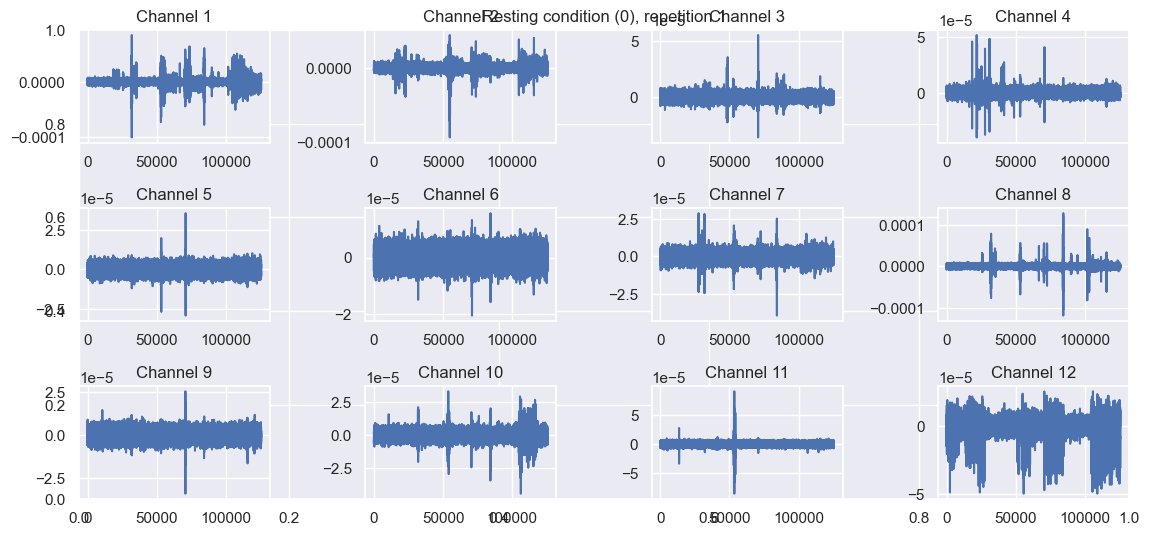

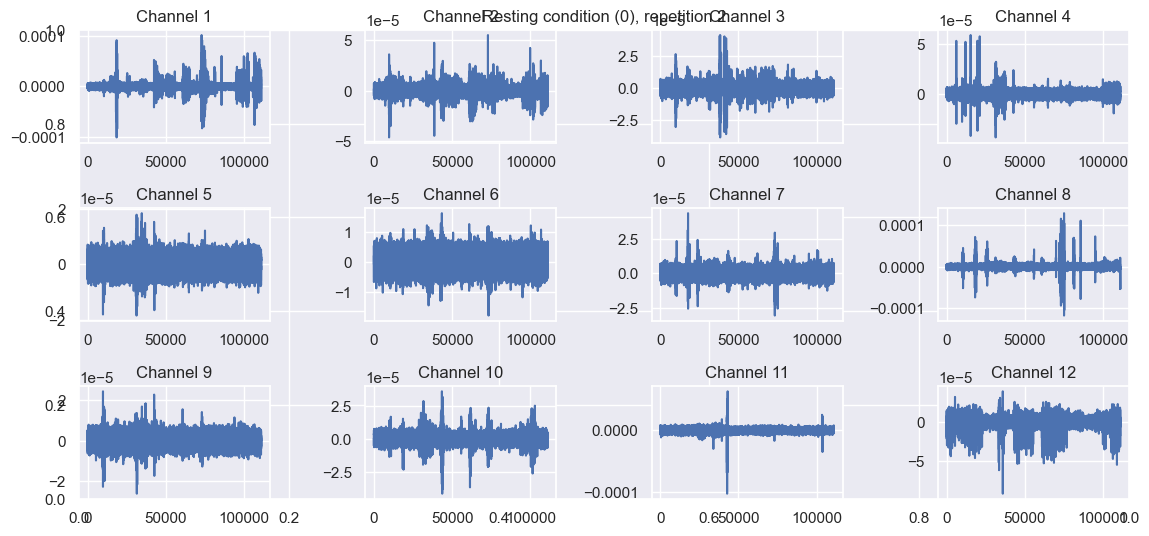

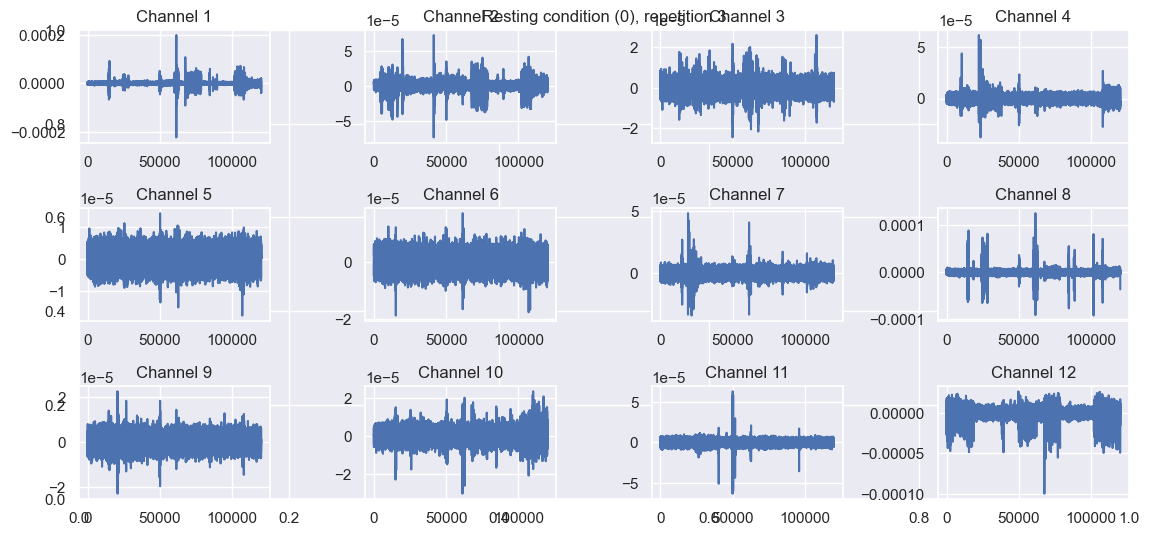

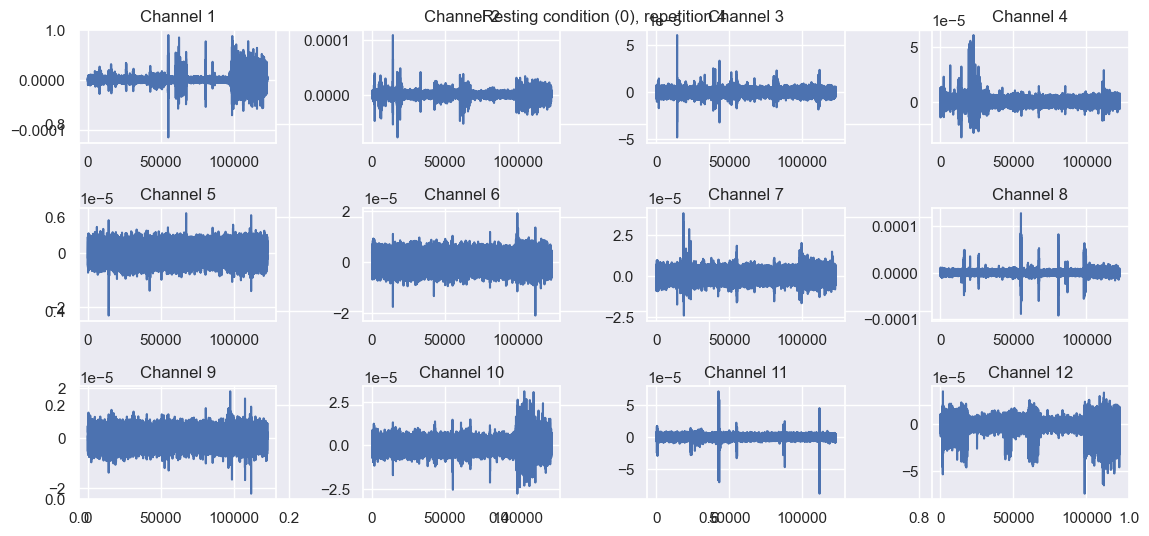

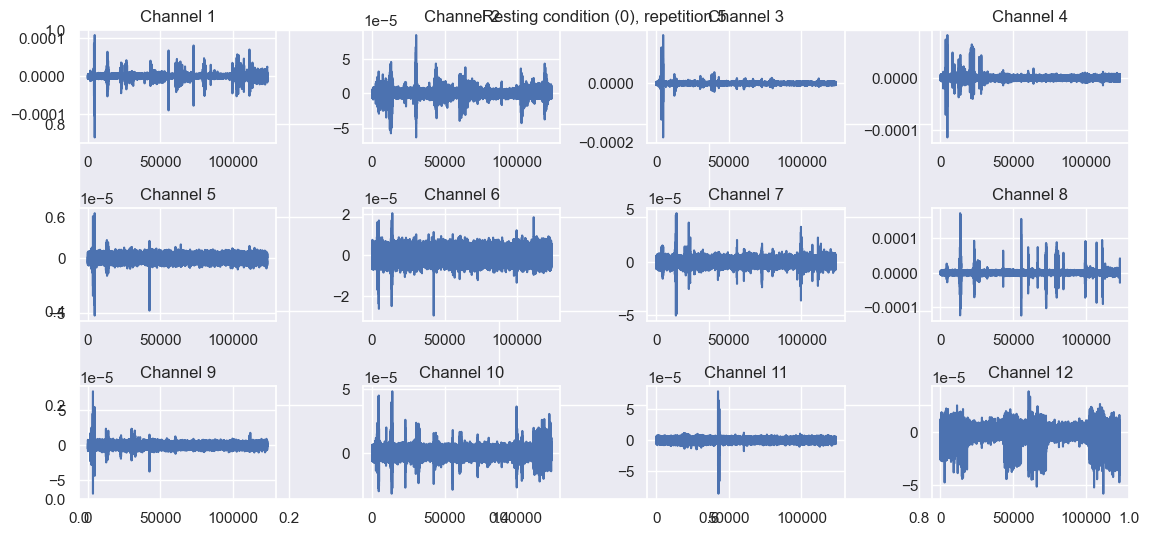

In [63]:
# Channel 1-8 : equally spaced electrodes on the forearm
# Channel 9-10 : Flexor Digitorum Superficialis and Extensor Digitorum Superficialis muscles
# Channel 11-12 : Biceps Brachii and Triceps Brachii muscles

# Plot signal for rest (0)
for rep in range(n_repetitions):
    plt.figure(figsize=(12, 6))
    plt.title(f"Resting condition (0), repetition {rep+1}")
    for channel_idx in range(n_channels): 
        plt.subplot(3, 4, channel_idx+1)
        plt.plot(emg_windows[0][rep][:, channel_idx])
        plt.title(f"Channel {channel_idx+1}")
    plt.tight_layout()
    plt.show()

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")

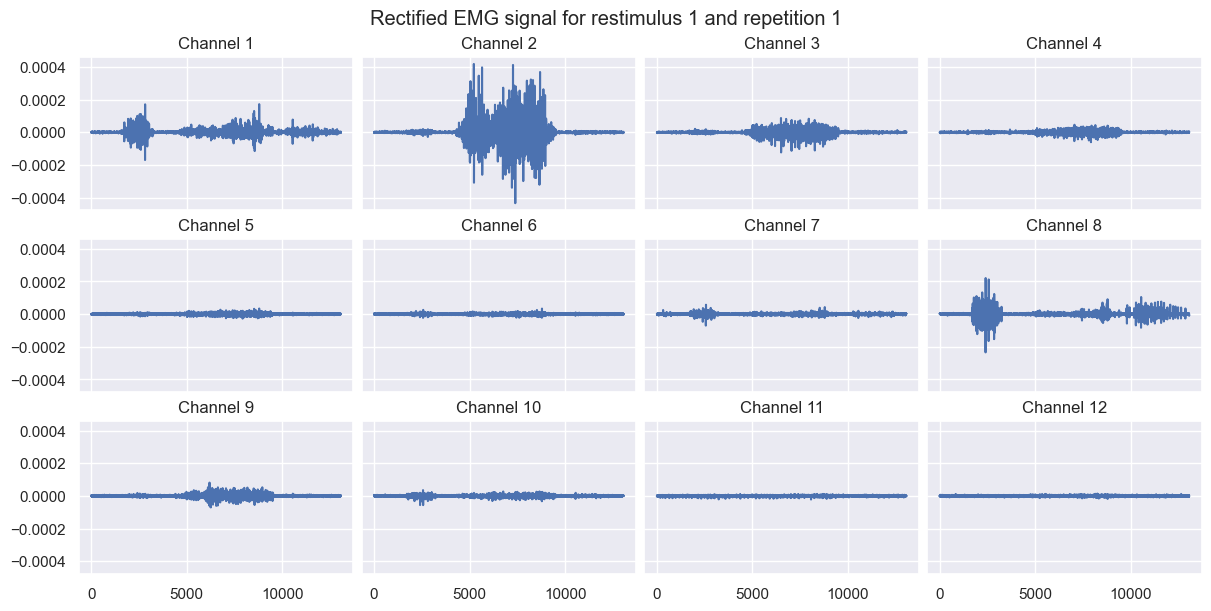

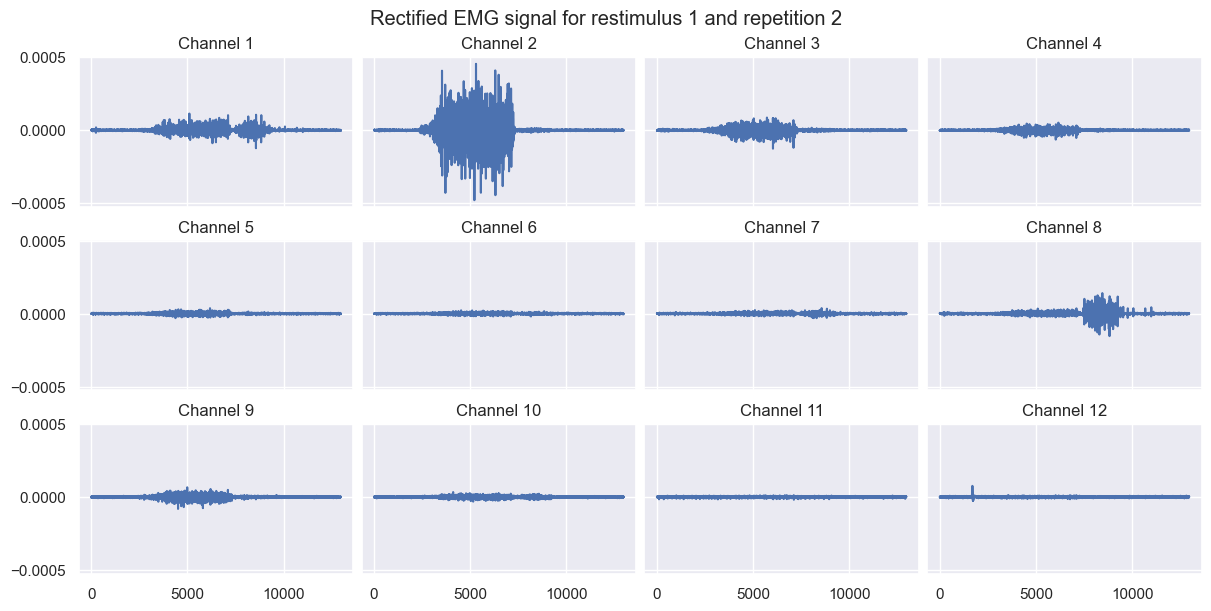

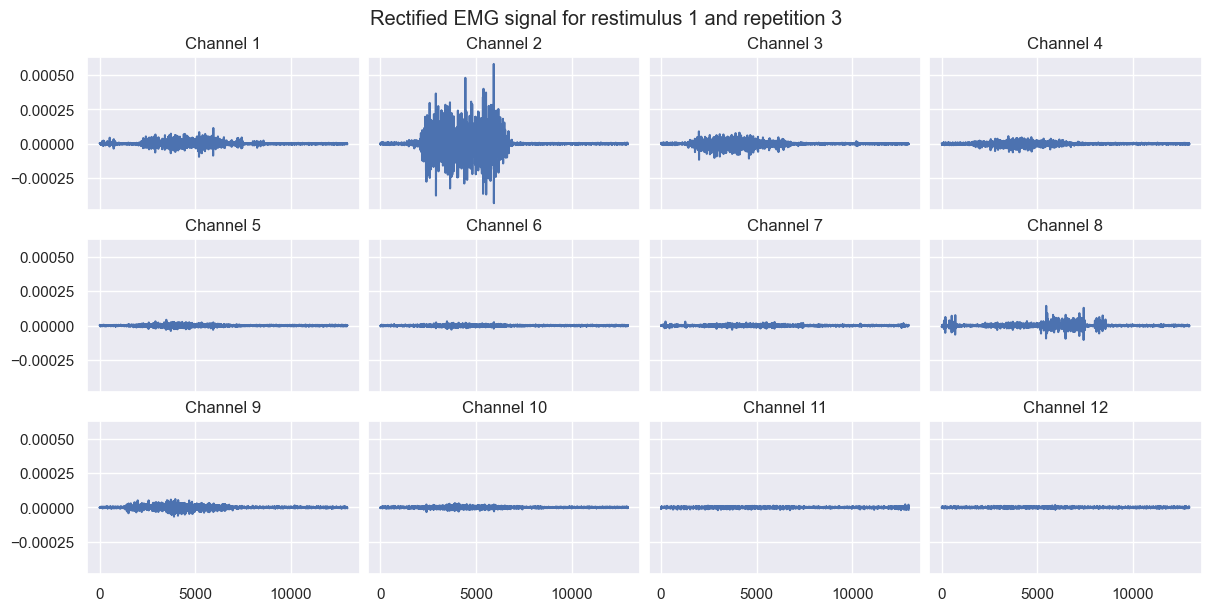

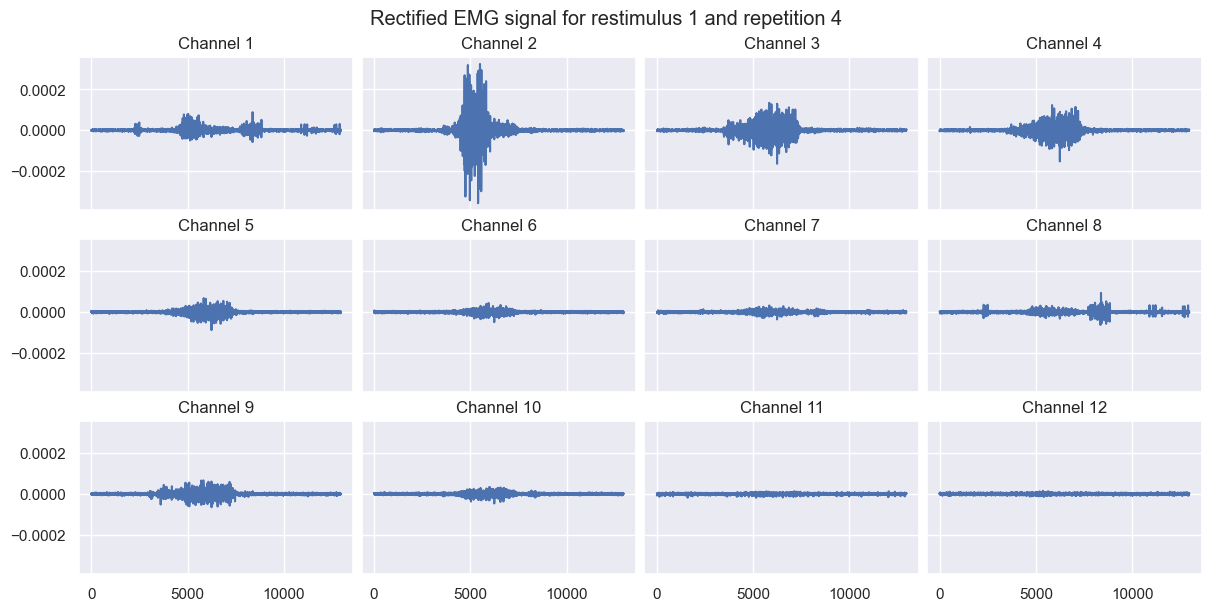

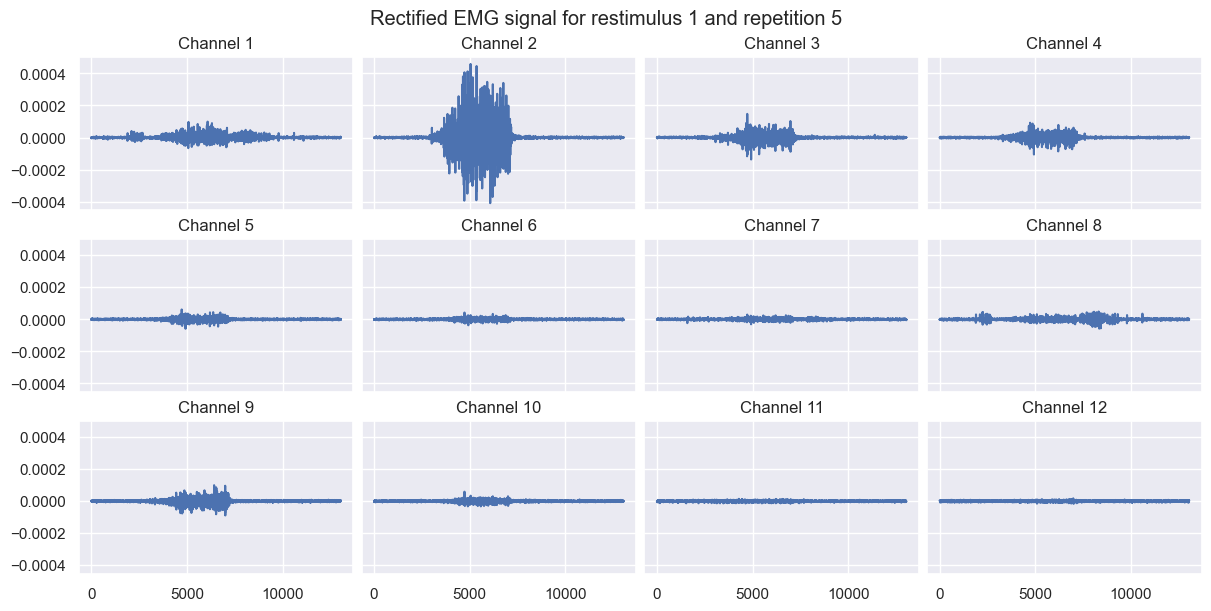

In [62]:
# Plot signal for fist action (6)

for rep in range(n_repetitions):
    fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    #10 EMG channels
    number_of_emg_channels = emg_rectified.shape[-1]
    # plot Rectified EMG signal
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(emg_windows[6][rep][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle(f"Rectified EMG signal for restimulus 1 and repetition {rep+1}")

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[6][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")


# # Envelopes
# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_envelopes[6][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")

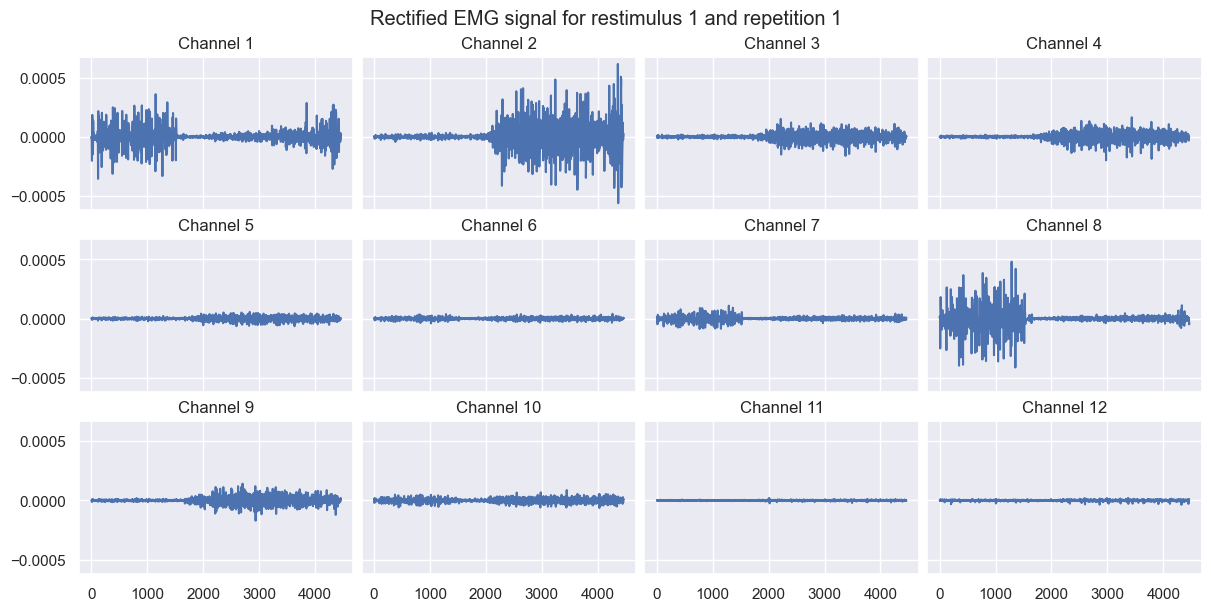

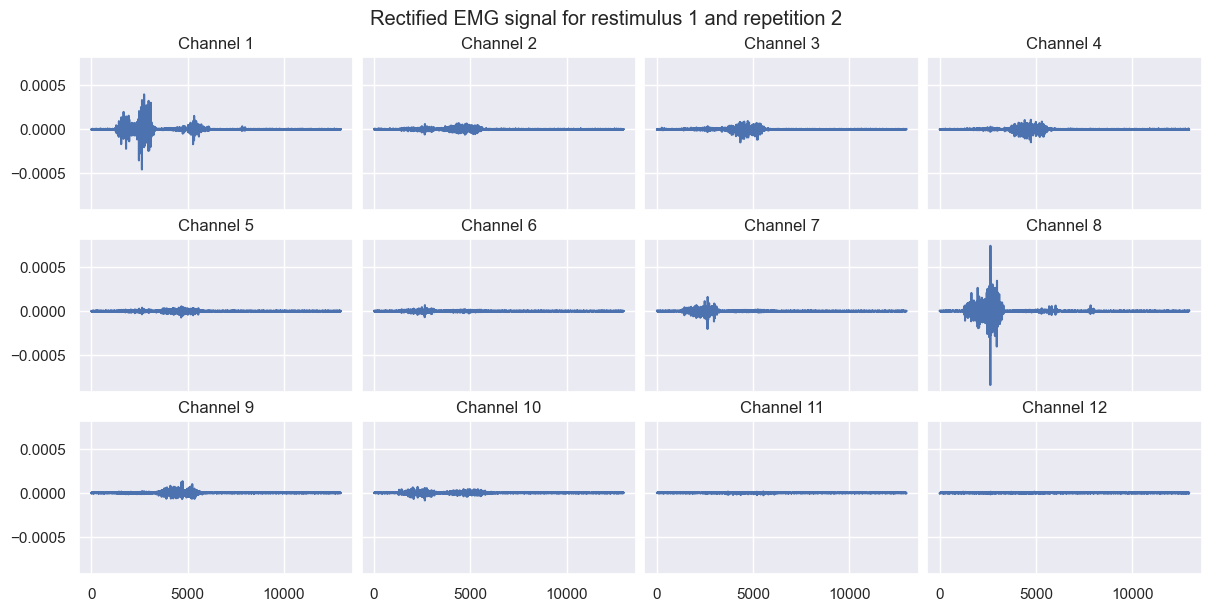

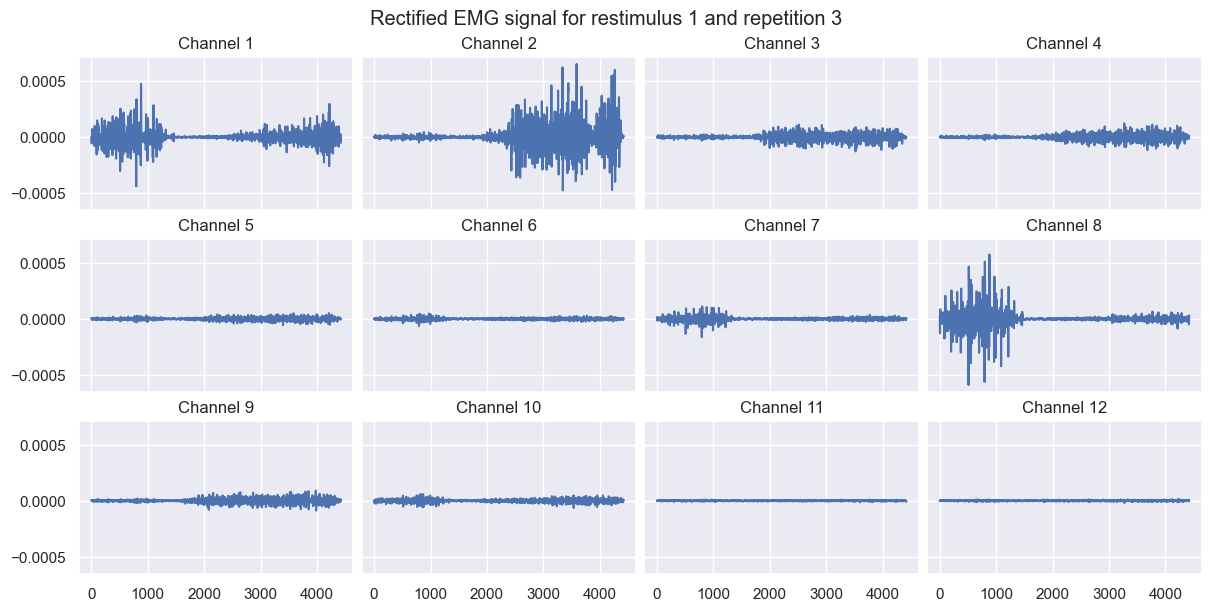

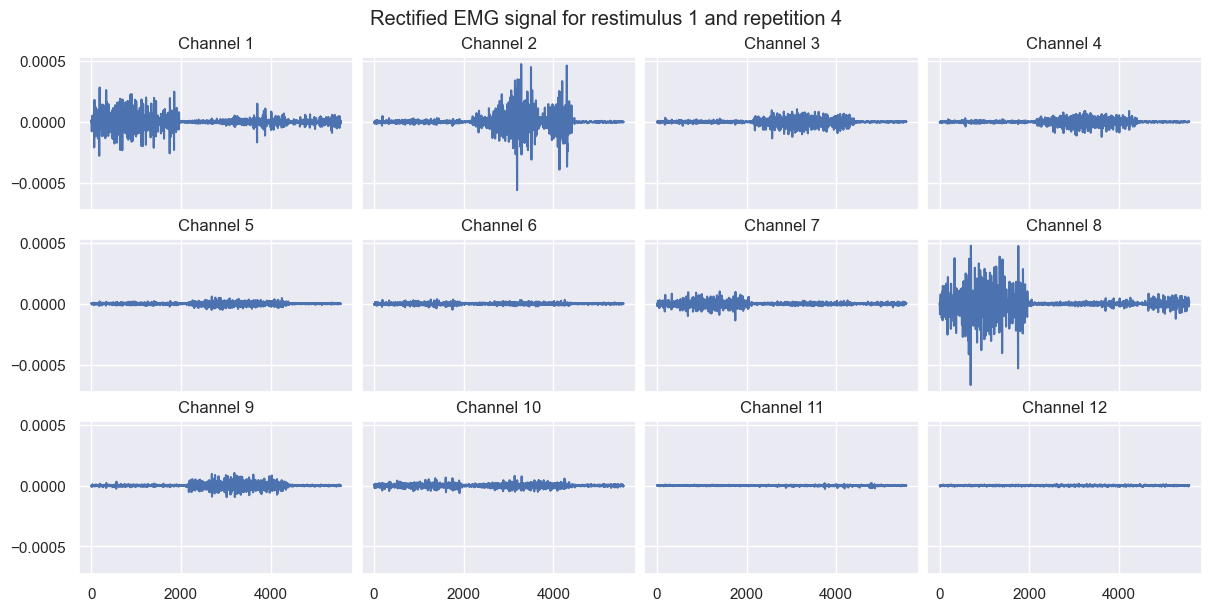

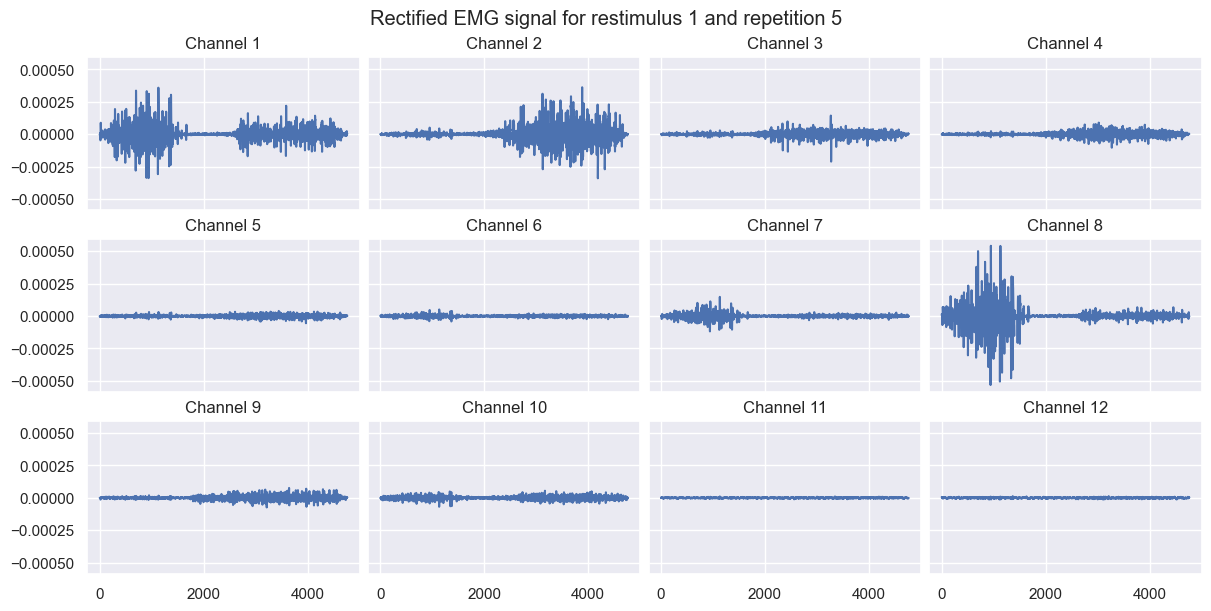

In [64]:
# Plot signal for wrist flexion action (13)
for rep in range(n_repetitions):
    fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    #10 EMG channels
    number_of_emg_channels = emg_rectified.shape[-1]
    # plot Rectified EMG signal
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(emg_windows[13][rep][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle(f"Rectified EMG signal for restimulus 1 and repetition {rep+1}")

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[13][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")

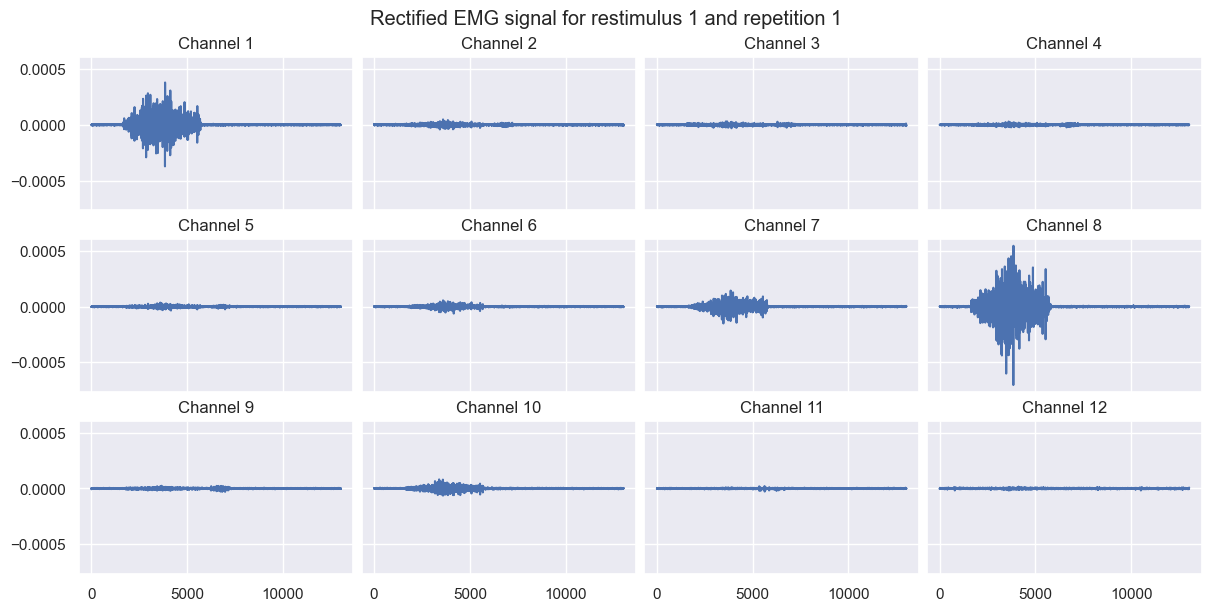

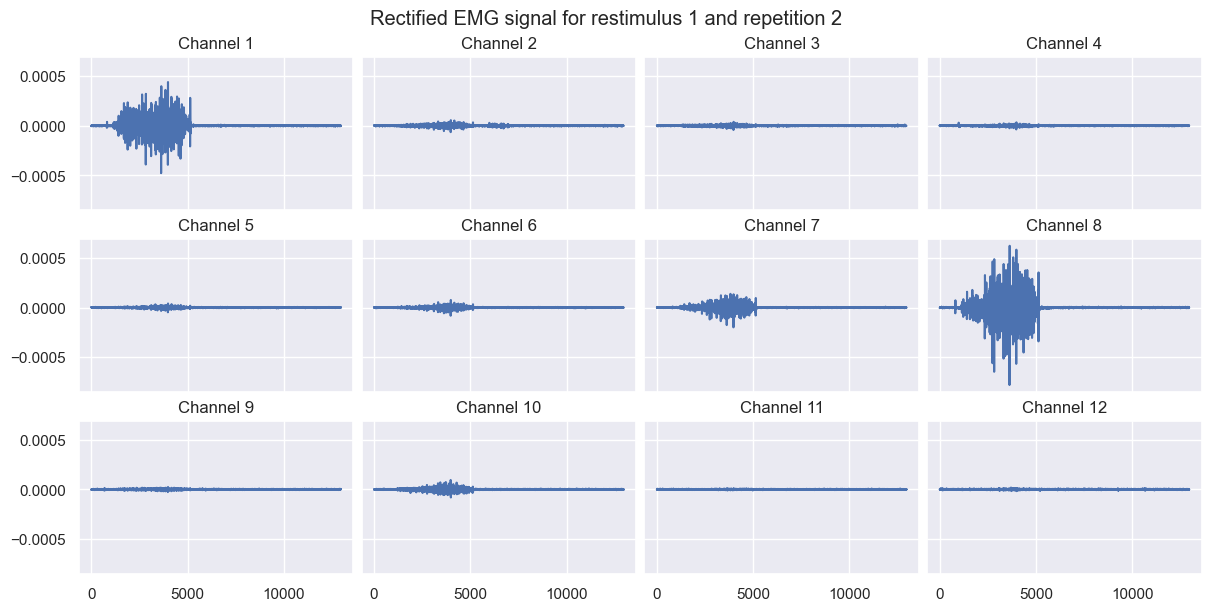

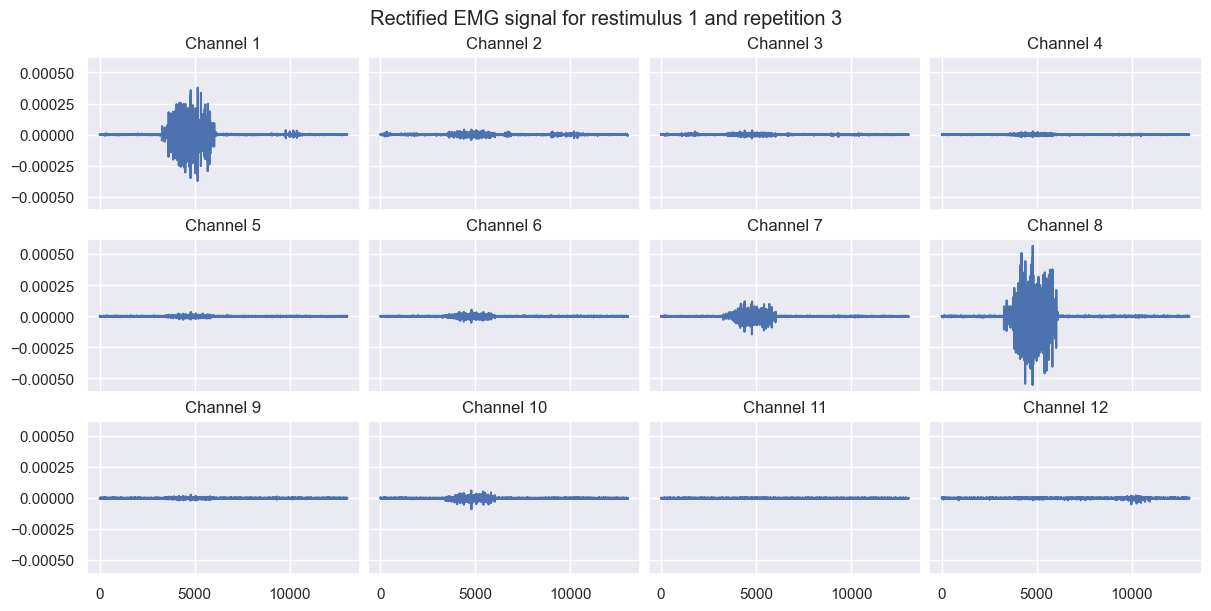

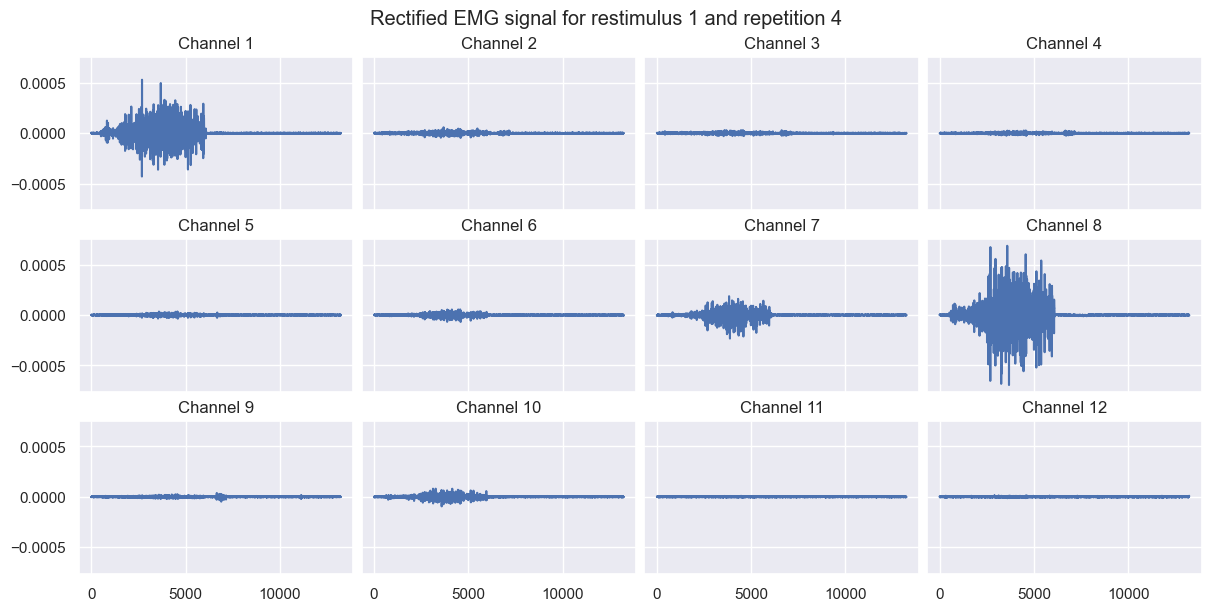

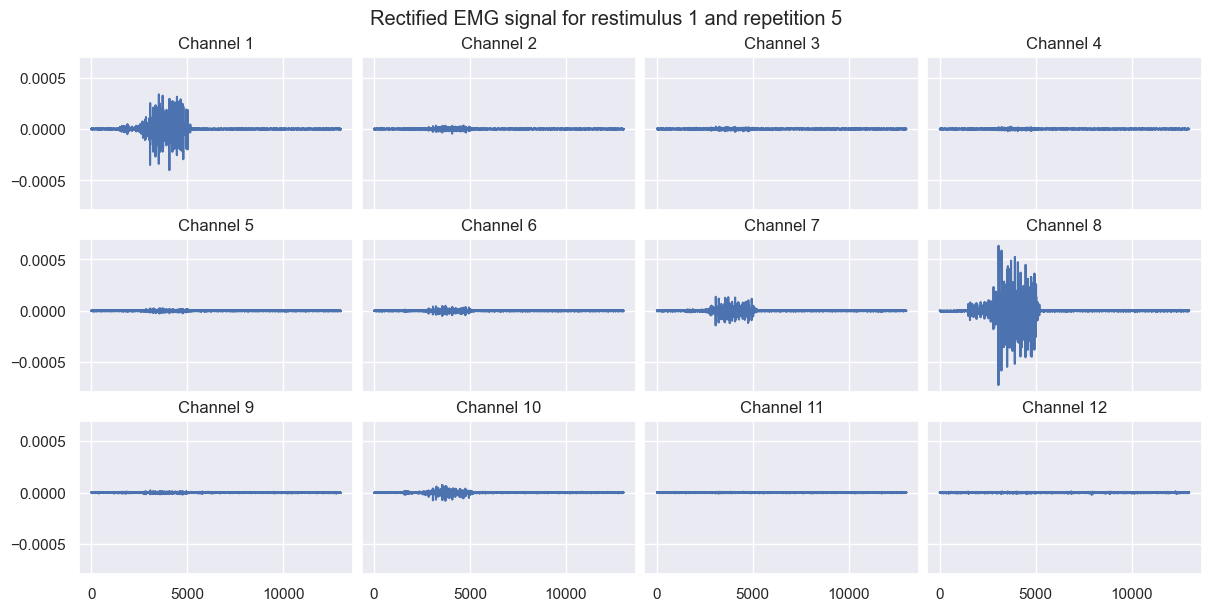

In [65]:
# Plot signal for wrist extension action (14)
for rep in range(n_repetitions):
    fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    #10 EMG channels
    number_of_emg_channels = emg_rectified.shape[-1]
    # plot Rectified EMG signal
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(emg_windows[14][rep][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle(f"Rectified EMG signal for restimulus 1 and repetition {rep+1}")

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[14][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")

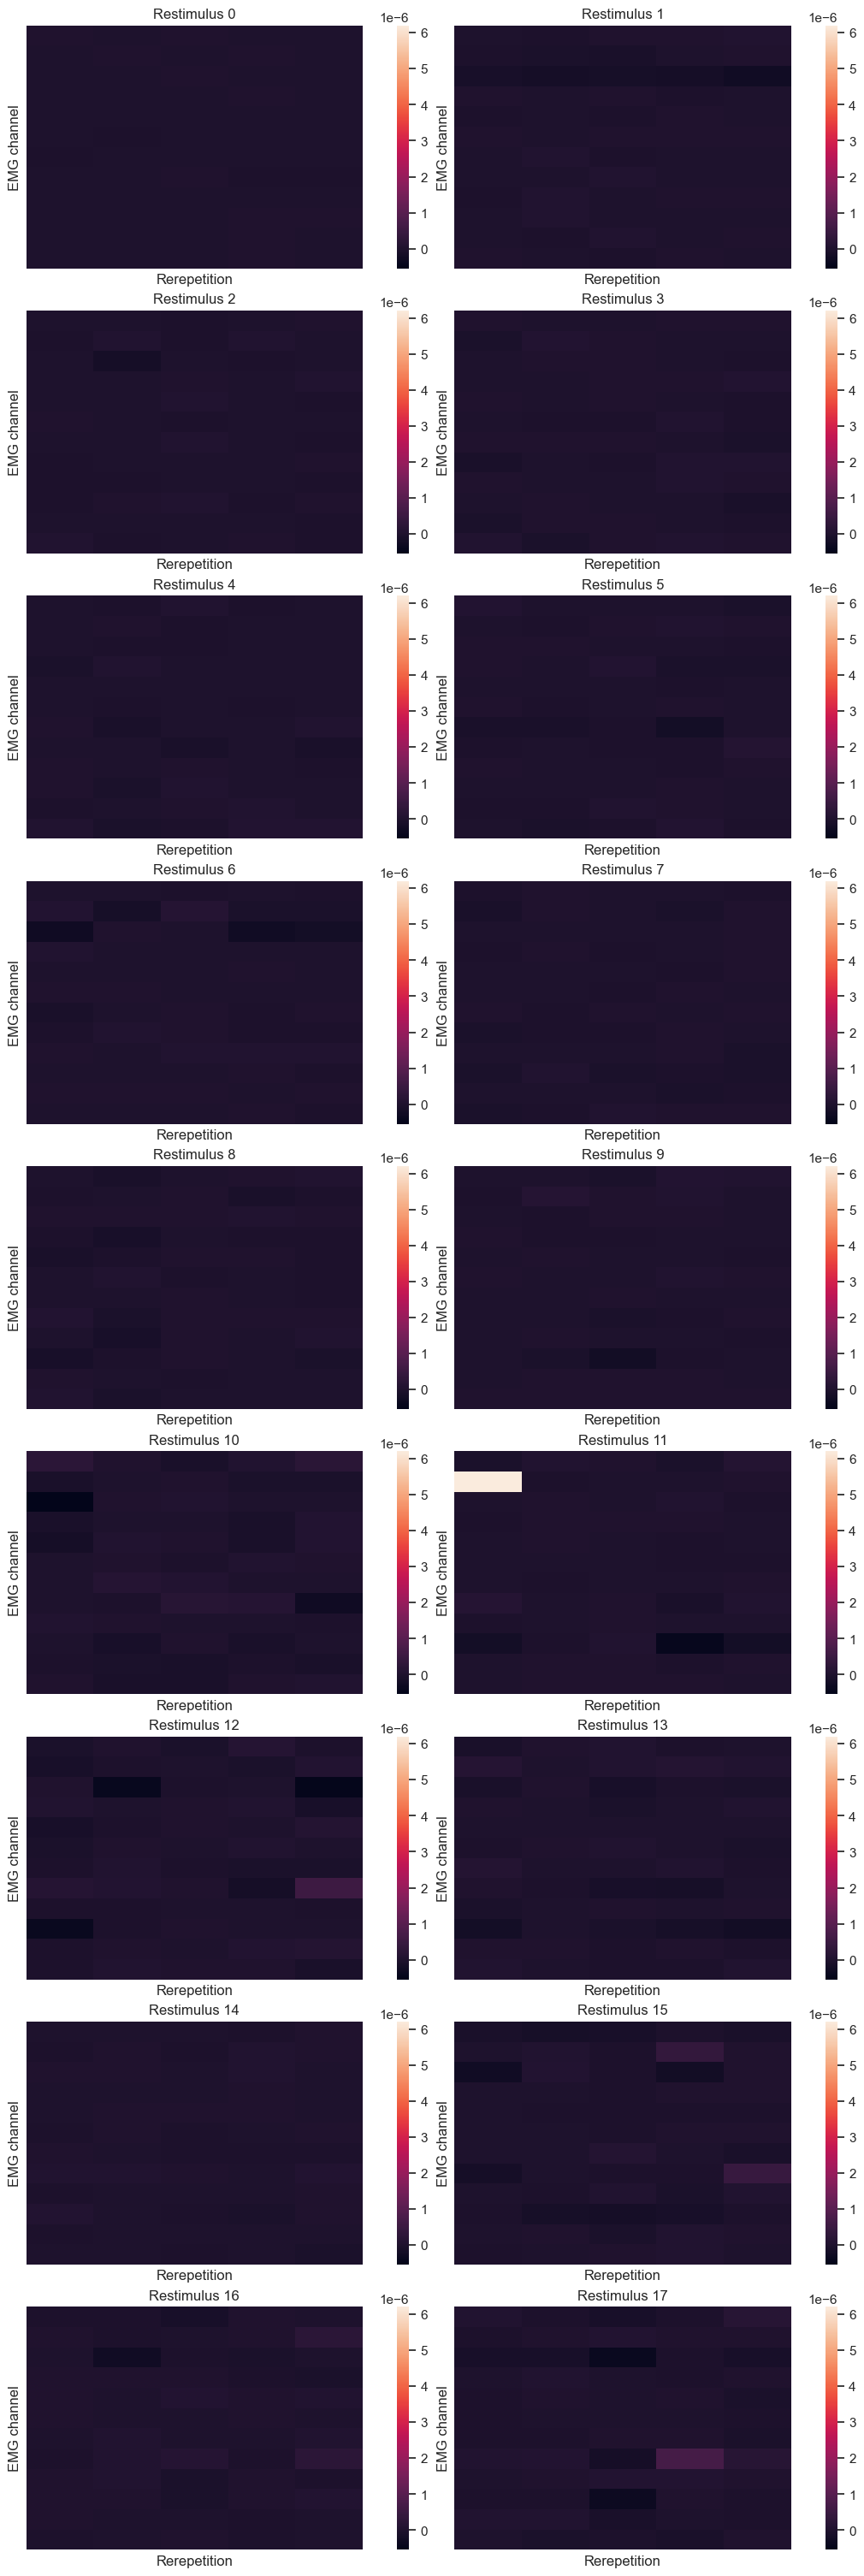

In [ ]:
emg_average_activations = np.zeros((n_channels, n_stimuli+1, n_repetitions))
for stimuli_idx in range(n_stimuli+1):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

vmin = np.min(emg_average_activations) 
vmax = np.max(emg_average_activations)

fig, ax = plt.subplots(9, 2, figsize=(10, 30), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli+1):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar=True, vmin=vmin, vmax=vmax,)
    ax[stimuli_idx].title.set_text("Restimulus " + str(stimuli_idx))
    ax[stimuli_idx].set_xlabel("Rerepetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

## Personal data

In [18]:
data_pers = pd.read_csv("data/pers_data/WS_R_4_250328161002.csv")
print(f"Data shape: {data_pers.shape}")
print(f"Data columns: {data_pers.columns}")

Data shape: (71990, 5)
Data columns: Index(['Timestamp', 'Channel1', 'Channel2', 'Action1', 'Action2'], dtype='object')


Text(0.5, 0.98, 'Rectified EMG signal for restimulus 1')

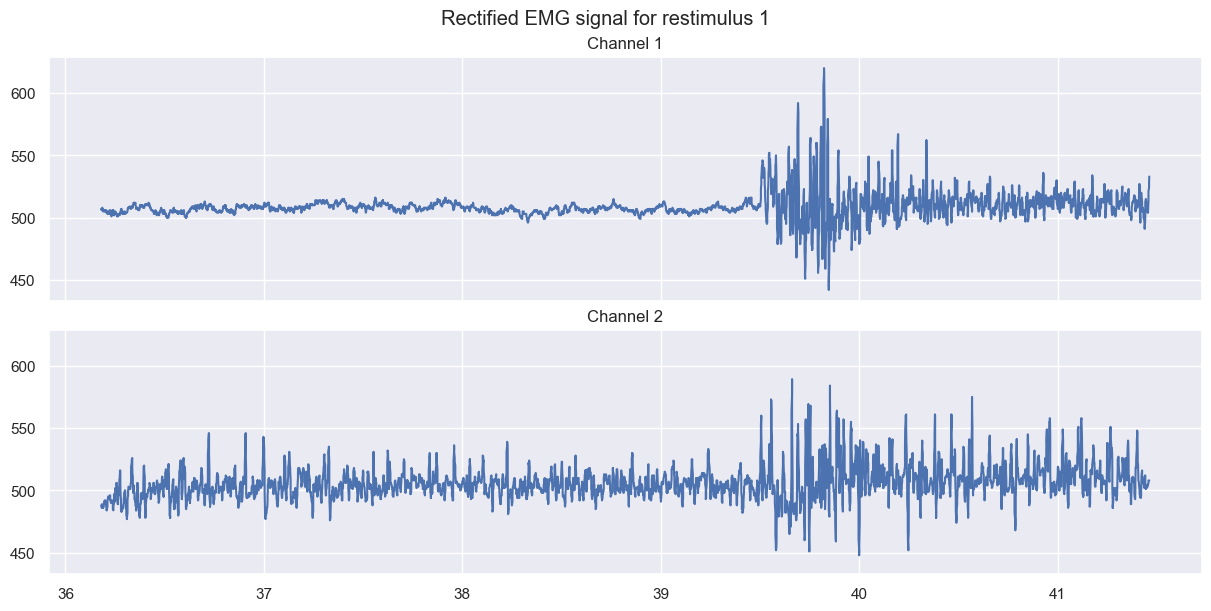

In [21]:
# Look for the first window of fist action
start_id = data_pers[(data_pers["Action1"] == "Rest") & (data_pers["Action2"] == "Fist")].index[0]
end_id = data_pers[(data_pers["Action1"] == "Fist") & (data_pers["Action2"] == "Rest")].index[-1]
window_df = data_pers.loc[start_id:end_id]

# plt.figure(figsize=(12, 4))
# plt.plot(window_df['Timestamp'], window_df['Channel1'], label='Channel1')
# plt.plot(window_df['Timestamp'], window_df['Channel2'], label='Channel2')
# plt.title("First 'Fist' Action Window")
# plt.xlabel("Time (s)")
# plt.ylabel("Signal")
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

fig, ax = plt.subplots(2, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

#2 EMG channels
for channel_idx in range(2): 
    ax[channel_idx].plot(window_df['Timestamp'], window_df['Channel{}'.format(channel_idx+1)])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal for restimulus 1")


Text(0.5, 0.98, 'Rectified EMG signal for restimulus 1')

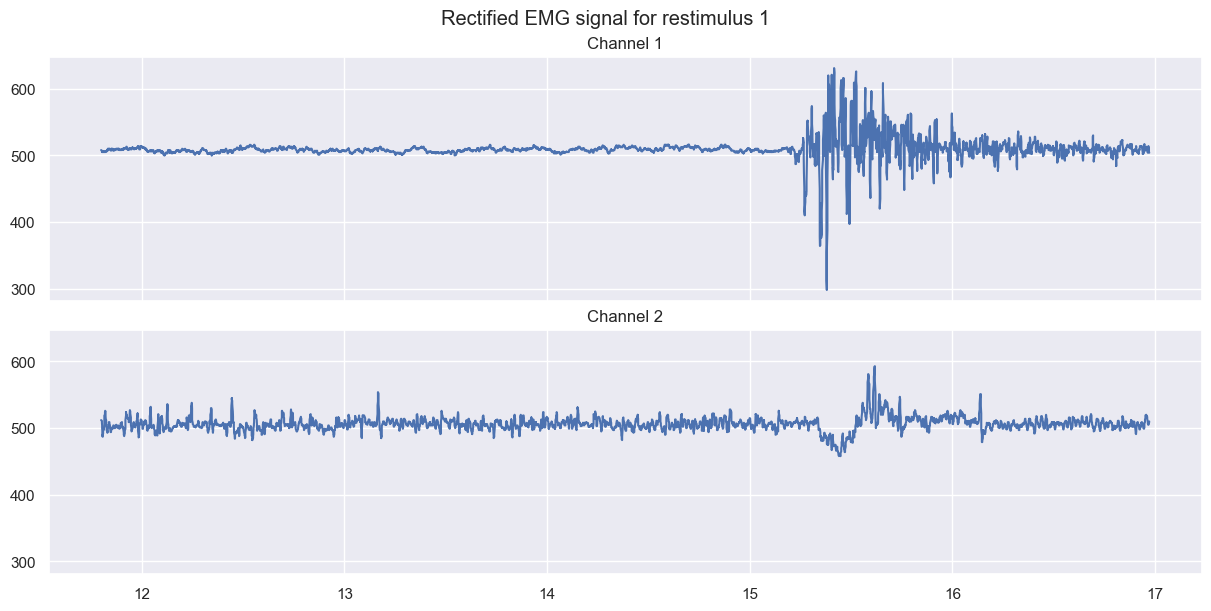

In [22]:
# Same for wrist flexion action
start_id = data_pers[(data_pers["Action1"] == "Rest") & (data_pers["Action2"] == "WristFlexion")].index[0]
end_id = data_pers[(data_pers["Action1"] == "WristFlexion") & (data_pers["Action2"] == "Rest")].index[-1]
window_df = data_pers.loc[start_id:end_id]

fig, ax = plt.subplots(2, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

#2 EMG channels
for channel_idx in range(2): 
    ax[channel_idx].plot(window_df['Timestamp'], window_df['Channel{}'.format(channel_idx+1)])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal for restimulus 1")


Text(0.5, 0.98, 'Rectified EMG signal for restimulus 1')

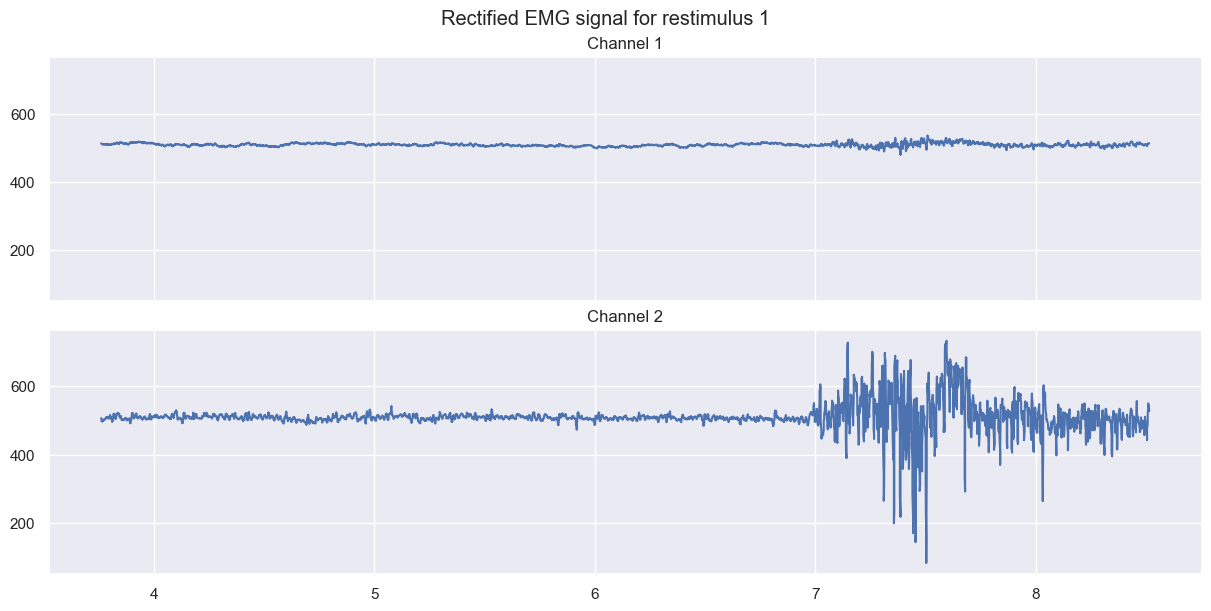

In [70]:
# Same for wrist extension action
start_id = data_pers[(data_pers["Action1"] == "Rest") & (data_pers["Action2"] == "WristExt")].index[0]
end_id = data_pers[(data_pers["Action1"] == "WristExt") & (data_pers["Action2"] == "Rest")].index[-1]
window_df = data_pers.loc[start_id:end_id]

fig, ax = plt.subplots(2, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

#2 EMG channels
for channel_idx in range(2): 
    ax[channel_idx].plot(window_df['Timestamp'], window_df['Channel{}'.format(channel_idx+1)])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal for restimulus 1")

# Correlation of channels between dataset

In [71]:
def compute_flat_label(row):
    if row['Action1'] == 'Rest' and pd.isna(row['Action2']): # return 'Rest' if Action1 is 'Rest' and Action2 is NaN
        return 'Rest'
    elif row['Action1'] != 'Rest' and pd.isna(row['Action2']): # if Action2 is NaN, return Action1 (except for 'Rest')
        return row['Action1']
    else:
        return row['Action2']  # transition phase, but will be merged into gesture


In [83]:
# Create single label for each row
data_pers_copy = data_pers.copy()
data_pers_copy.drop(index=0, inplace=True)
data_pers_copy['Gesture'] = data_pers_copy.apply(compute_flat_label, axis=1)
data_pers_copy.drop(columns=['Action1', 'Action2'], inplace=True)

In [84]:
data_pers_copy.head()

,Timestamp,Channel1,Channel2,Gesture
1,0.161,506.0,480.0,Rest
2,0.161,506.0,479.0,Rest
3,0.161,506.0,477.0,Rest
4,0.162,506.0,475.0,Rest
5,0.162,507.0,472.0,Rest


## Resample Ninapro and personnal data at 1000Hz

In [85]:
from scipy.signal import resample
from scipy.stats import mode

def downsample_dataframe_with_labels(df, target_freq, time_col='Timestamp', label_cols=None, method='resample'):
    """
    Downsamples a DataFrame with timestamp, signal columns, and optional label columns.
    
    Parameters:
        df : pd.DataFrame
            Input data (must include a time column).
        target_freq : int
            Target sampling frequency in Hz.
        time_col : str
            Name of the time column.
        label_cols : list of str
            Columns with categorical labels (e.g., ['FlatLabel', 'Action1', 'Action2']).
        method : str
            'resample' (FFT-based) or 'average' (bin-average + mode for labels).
    
    Returns:
        pd.DataFrame
            Downsampled DataFrame with aligned time, signal, and label columns.
    """
    if time_col not in df.columns:
        raise ValueError(f"{time_col} must be in dataframe")

    label_cols = label_cols or []
    all_cols = df.columns.tolist()
    signal_cols = [col for col in all_cols if col not in [time_col] + label_cols]

    t_orig = df[time_col].values
    t_start, t_end = t_orig[0], t_orig[-1]
    duration = t_end - t_start
    n_target = int(duration * target_freq)

    # Downsample signals
    if method == 'resample':
        signals_ds = pd.DataFrame(
            resample(df[signal_cols].values, n_target),
            columns=signal_cols
        )
    elif method == 'average':
        df_indexed = df.set_index(time_col)
        df_indexed.index = pd.to_datetime(df_indexed.index, unit='s')
        signals_ds = df_indexed[signal_cols].resample(f"{int(1000/target_freq)}ms").mean().dropna().reset_index(drop=True)
    else:
        raise ValueError("method must be 'resample' or 'average'")

    # Generate new time vector
    t_uniform = np.linspace(t_start, t_end, n_target, endpoint=False)
    signals_ds.insert(0, time_col, t_uniform)

    # Downsample labels using mode per time bin
    if label_cols:
        df_label = df[[time_col] + label_cols].copy()
        df_label.index = pd.to_datetime(df_label[time_col], unit='s')

        bin_size_ms = int(1000 / target_freq)
        label_resampled = []

        for col in label_cols:
            grouped = df_label[col].resample(f"{bin_size_ms}ms").agg(lambda x: mode(x, nan_policy='omit')[0][0] if len(x) > 0 else np.nan)
            label_resampled.append(grouped)

        label_df = pd.concat(label_resampled, axis=1)
        label_df.columns = label_cols
        label_df = label_df.dropna().reset_index(drop=True)

        # Align label_df to signal df
        label_df = label_df.iloc[:len(signals_ds)]
        signals_ds[label_cols] = label_df

    return signals_ds


In [86]:
downsampled_data_pers = downsample_dataframe_with_labels(data_pers_copy, target_freq=1000, time_col='Timestamp', label_cols=['Gesture'], method='resample')
downsampled_data_pers.head()

C:\Users\willi\AppData\Local\Temp\ipykernel_5736\1412310108.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  grouped = df_label[col].resample(f"{bin_size_ms}ms").agg(lambda x: mode(x, nan_policy='omit')[0][0] if len(x) > 0 else np.nan)
C:\Users\willi\AppData\Local\Temp\ipykernel_5736\1412310108.py:62: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  grouped = df_label[col].resample(f"{bin_size_ms}ms").agg(lambda x: mode(x, nan_po

,Timestamp,Channel1,Channel2,Gesture
0,0.161,506.563501,485.129273,Rest
1,0.162,505.733262,476.562931,Rest
2,0.163,506.334381,475.847130,Rest
3,0.164,506.499527,471.007409,Rest
4,0.165,506.016417,469.827840,Rest


In [98]:
np.shape(data_DB3_s1_E1['emg'])

(1825008, 12)

In [100]:
# Create an empty DataFrame to store the data
data_ninapro = pd.DataFrame()
# data_ninapro['Timestamp'] = data_DB3_s1_E1['timestamp'].flatten()
# data_ninapro['EMG'] = emg_rectified.flatten()
for channel in range(n_channels):
    data_ninapro[f'Channel{channel+1}'] = emg_rectified[:, channel].flatten()
data_ninapro['Stimulus'] = stimulus.flatten()
data_ninapro['Repetition'] = repetition.flatten()
data_ninapro['Restimulus'] = restimulus.flatten()
data_ninapro['Rerepetition'] = rerepetition.flatten()

sampling_rate = 2000  # Hz (samples per second)
n_samples = data_ninapro.shape[0]
data_ninapro['Timestamp'] = np.arange(n_samples) / sampling_rate  # Create a timestamp column


In [102]:
data_ninapro.head()

,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,Channel11,Channel12,Stimulus,Repetition,Restimulus,Rerepetition,Timestamp
0,0.000004,-2.786037e-07,-0.000005,-6.351953e-07,-1.512986e-07,0.000001,-1.483299e-06,-0.000004,2.491953e-06,-0.000004,1.612457e-06,4.699033e-06,0,0,0,1,0.0000
1,0.000005,-1.285415e-06,-0.000003,7.074447e-07,-3.191196e-07,-0.000002,-6.441234e-07,-0.000004,2.827591e-06,-0.000004,1.276554e-06,3.524141e-06,0,0,0,1,0.0005
2,0.000004,-3.970727e-06,-0.000003,7.072846e-07,-1.494141e-06,-0.000003,5.308528e-07,-0.000004,2.156130e-06,-0.000006,1.276352e-06,1.509949e-06,0,0,0,1,0.0010
3,0.000003,-4.306138e-06,-0.000004,3.572455e-08,-3.004762e-06,-0.000003,8.665290e-07,-0.000004,-1.938318e-07,-0.000005,1.779749e-06,5.028567e-07,0,0,0,1,0.0015
4,0.000003,-6.131493e-07,-0.000003,-1.322356e-07,-3.508384e-06,-0.000004,6.986052e-07,-0.000003,-2.543793e-06,-0.000003,6.045457e-07,2.181365e-06,0,0,0,1,0.0020


In [103]:
data_ninapro_copy = data_ninapro.copy()
downsampled_data_ninapro = downsample_dataframe_with_labels(data_ninapro_copy, target_freq=1000, time_col='Timestamp', label_cols=['Stimulus', 'Repetition', 'Restimulus', 'Rerepetition'], method='resample')
downsampled_data_ninapro.head()

C:\Users\willi\AppData\Local\Temp\ipykernel_5736\1412310108.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  grouped = df_label[col].resample(f"{bin_size_ms}ms").agg(lambda x: mode(x, nan_policy='omit')[0][0] if len(x) > 0 else np.nan)


,Timestamp,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,Channel11,Channel12,Stimulus,Repetition,Restimulus,Rerepetition
0,0.000,0.000004,3.421130e-07,-0.000004,-7.395218e-07,-1.648205e-07,-0.000001,-2.462329e-06,-0.000003,2.178590e-06,-0.000005,9.750480e-07,8.729874e-07,0,0,0,1
1,0.001,0.000004,-4.112867e-06,-0.000004,8.034041e-07,-1.258258e-06,-0.000002,7.390273e-07,-0.000005,2.081342e-06,-0.000005,1.550235e-06,2.855237e-06,0,0,0,1
2,0.002,0.000003,-8.064127e-07,-0.000003,-2.994702e-07,-3.919208e-06,-0.000004,4.794938e-07,-0.000003,-2.425310e-06,-0.000003,6.500644e-07,7.891234e-07,0,0,0,1
3,0.003,0.000004,2.282617e-06,-0.000003,-1.401341e-07,-4.994414e-07,-0.000003,5.482524e-07,-0.000004,5.588637e-08,-0.000001,-8.470170e-07,4.445305e-06,0,0,0,1
4,0.004,0.000004,2.605559e-06,-0.000005,-7.612063e-07,-2.968801e-06,-0.000004,3.764431e-06,-0.000006,6.121387e-06,-0.000001,7.550654e-07,5.035874e-06,0,0,0,1


## Correlation between channels

In [49]:
# Map personnal labels to Ninapro labels

movement_ExA = {
    0: "Rest",
    1: "IndexFlex",
    3: "MiddleFlex",
    5: "RingPinkyFlex",
    7: "RingPinkyFlex",
    9: "ThumbAdd",
    10: "ThumbAbd",
    11: "ThumbFlex",
}

movement_ExB = {
    0: "Rest",
    1: "ThumbUp",
    2: "Scisors",
    5: "Palm",
    6: "Fist",
    9: "WristRotIn",
    10: "WristRotExt",
    13: "WristFlexion",
    14: "WristExt",
}

movement_ExC = {
    0: "Rest",
    1: "CylindGraspClosed",
    2: "CylindGraspClosed",
    3: "HookGraspClosed",
    14: "PinchGraspClosed",
    15: "PinchGraspClosed",
    19: "LumbGraspClosed",
}

pers_gestures = {"Rest", "Fist", "WristFlexion", "WristExt", "WristRotIn", "WristRotExt", "Palm"}

gesture_to_id = {v: k for k, v in movement_ExB.items() if v in pers_gestures}